# Dynamic Circuits と "Repeat until success"入門

## はじめに

>_「量子回路とは、量子データ(量子ビットなど)に対するコヒーレントな量子演算と、リアルタイム同時古典計算で構成される計算ルーチンのことです。量子回路は、量子ゲート 、測定 、リセットの順序立てられたシーケンスであり、これらはすべてリアルタイム古典計算のデータを使用した条件付ゲートが作用することがあります。」_

この定義の最後の部分はあまり聞き慣れないかもしれませんが、これは動的回路（Dynamic circuits）に関係するものです。通常量子回路の話をするときは、明示的に言わないまでも静的な量子回路を指しています。では、Dynamic circuitsとは何でしょうか？

**Dynamic circuits**とは、量子回路の途中で測定が行われ、その測定結果をもとに回路内の量子ゲートを条件付けることができる回路です。このように、古典的な測定結果をもとに将来の量子演算を条件付ける機能を古典フィードフォワードと呼びます。

なぜ古典フィードフォワードが必要なのでしょうか？  例を挙げましょう。  
Qiskitの条件付きリセット操作を考えてみましょう。[`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html)操作を使ったことがある人なら聞き覚えがあるかもしれません。リセット操作は初期状態に関係なく量子ビットをゼロ状態にリセットする非ユニタリー操作です。操作はすでに測定された量子ビットに対して実行され、測定値から判断して量子ビットが1状態にある場合にのみビットフリップXゲートを適用してゼロ状態にリセットします。  
この操作は、すでに測定された量子ビットをより速く、エラーを少なくリセットする方法となり得ます。

![](./resources/2023-spring-lab1-sketch-1.png)

別の言い方をすればDynamic circuitsとは、if文やwhileループなどの制御フローを含む量子回路で、述語は過去の量子ビット測定結果から計算され、条件演算は量子ゲートを含みます。

> predicate(述語): 量子状態の特定の性質や条件を表したもの

## Hello Dynamic Circuit World

IBM Quantumハードウェアはすでに回路途中の測定とリセットをサポートしていました。しかし古典フィードフォワードのサポートを追加するには、制御システムと関連するソフトウェアスタックを大幅に再設計する必要がありました。Dynamic circuitsの完全なサポートは、2022年になってから導入されました。

QiskitではDynamic circuitをプログラミングするための構文が何度か取り入れられていますが、まだ完全なサポートは実装されていません。現在のところは、Dynamic circuitの全機能にアクセスするにはOpenQASM3で書かれたプログラムを提出するしかないのです。とはいえ、今回のチャレンジではQiskitで現在利用可能な機能を使って取り組んでいただきます。

Qiskitの以前のバージョンでは[`c_if()`](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html)命令が使われていましたが、この構文は今後非推奨となる予定です。というのもQuantumCircuitクラスにはより柔軟な[`if_test()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html)メソッドがあり、今回のチャレンジではこちらを主に使用します。

手始めに、この機能を使った簡単な例を確認しましょう。次の手順で、条件付きリセット回路を作ることにします。

1. 1量子ビットと2古典ビットで回路を初期化する。($q_{0}$、$b_{0}$、$b_{1}$)
2. $q_{0}$にアダマールゲートを適用する。
3. その量子ビットを測定し、その結果を$b_{0}$に保存する。
4. $b_{0}$が1の場合`if_test`ブロックを開始する。
5. `if_test`ブロックの中で条件を満たした場合に行う操作を指定する。（今回は$q_{0}$を0状態に反転させます。）
6. 再度$q_0$を$b_{1}$に測定し、常に結果が0となることを確認する。

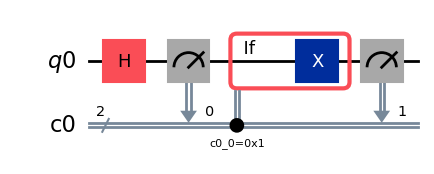

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

回路ができたので何度か動かしてみて常に期待通りの出力が得られるかどうか確認してみましょう。最初の測定は0でも1でも構いませんが、2回目の測定は必ず0になるはずです。

In [2]:
from qiskit_aer import AerSimulator

# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'00': 529, '01': 495}


期待通り最初のビットは0になったり1になったりしますが、2番目のビットは常に0です。

```{important}
Qiskitはリトルエンディアンのビット順を採用しているので、右端のビットが1番目のビット、左端のビットが最後のビットになることを思い出してください。
```

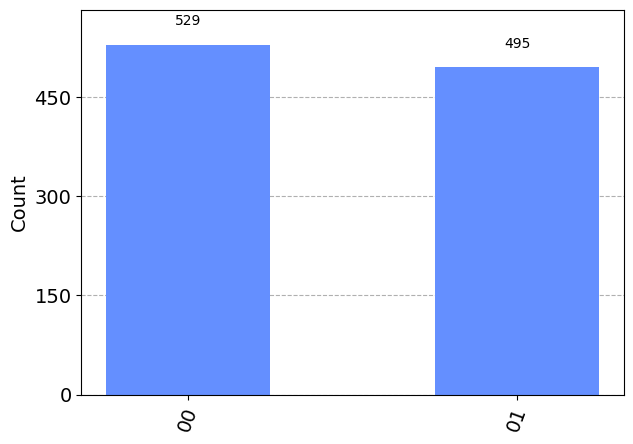

In [3]:
from qiskit.visualization import plot_histogram

# plot histogram
plot_histogram(reset_sim_counts)

これで、初めてのDynamic circuitを作る準備ができました！

````{admonition} Exercise1: 2量子ビット回路の構築
レベルを上げましょう。最初の課題は2量子ビット回路を設計することです。この場合$q_{0}$の値によって$q_{1}$に異なる動作をさせることが目的となります。$q_{0}$の測定値が0なら$q_{1}$に$X$ゲートを適用します。1であれば代わりに$q_{1}$にアダマールゲートを適用します。

$q_{0}$の値をランダムにするために、まずアダマールゲートを適用します。次に、$q_{0}$を測定して$b_{0}$に書き込みます。そうすると、動的なマジックが起こるはずです。最後に$q_{1}$を測定します。

このExerciseでは [`if_test()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) のドキュメントを読むことをお勧めします。

```python
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)

####### your code goes here #######


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)
```
````

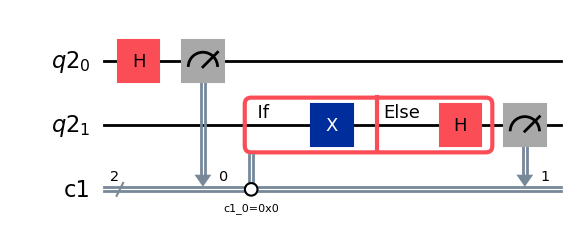

In [4]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)

####### your code goes here #######
with qc.if_test((b0, 0)) as else_:
    qc.x(q1)
with else_:
    qc.h(q1)

qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

オプションで、次のセルを実行して回路が期待通りに動作するかをチェックすることができます。
>Tip：回路を実行する前に起こりうる結果を考えて見てください。

In [5]:
backend_sim = AerSimulator()

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

print(f"Counts: {counts_1}")

Counts: {'01': 258, '11': 271, '10': 495}


## Repeat until success

プロセスの出力がランダムで得られる結果が望んだものでないことがあります。このような場合どうすればいいのでしょうか？もう一度やってみればいいのです！望む結果が得られる確率がゼロでない限り、プロセスを繰り返せば、最終的には期待した結果が得られることが保証されています。多くの場合ほんの数回の繰り返しで済みます。

このセクションでは "repeat until success" のアイデアを用いて$R_X(\theta)$ゲート(ただし$\theta / \pi$は無理数)を有限のゲートセット$\{H,\,X,\,S,\,\text{Toffoli}\}$から構築します。特に$\cos\theta = \frac35$の場合を考えます。この構成はNielsen and Chuangの _量子コンピュータと量子通信_, 10<sup>th</sup> anniversary edition, Exercise 4.41 からの引用したもので、上で与えられた有限のゲートセットの普遍性を示しています。

作り方は、3つの量子ビットに作用する回路を作ることになります。そのうちの1つはターゲット量子ビットで、このターゲット量子ビットに対して$R_X(\theta)$ゲートを実行することが目標です。残りの2つの量子ビットは「シンドローム」量子ビットで、測定し、測定結果で操作が成功したかどうかを知ることができます。もし両方のシンドローム量子ビットが0を読み取ったら、ゲートが成功したことがわかります。そうでない場合は、量子ビットをリセットして再挑戦します。測定結果をもとに回路の繰り返しを条件付けるために、Dynamic circuitが必要になります。

````{admonition} Exercise2: 実験用量子回路の構築
このセクションの最初の課題は、上記の回路を返す関数を作成することです。回路のアウトプットイメージはこちらです。

![output](./resources/2023-spring-lab1-circuitRx.png)

```python
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    ####### your code goes here #######


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
qc.draw("mpl", cregbundle=False)
```
````

簡単にできるように、必要な要素を入れた「ベース」回路を用意してあります。このLabで書く関数は、回路を入力として受け取りその場で修正するものです。新しい回路が必要なときはベースとなる回路のコピーを作ればよいのです。

In [6]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

base = QuantumCircuit(controls, target, mid_measure, final_measure)

次のセルで、`trial`関数が以下のステップを踏んで回路を構成するようにしてください。

1. 制御レジスターの各量子ビットとターゲット量子ビットにアダマールゲートを適用する。
2. 制御レジスターとターゲット量子ビットの間にトフォリ（制御-制御-NOT）ゲートを適用する。これはQuantumCircuitの`ccx`メソッドを使うか、`qiskit.circuit.library`から`CCXGate`をインポートして使用することで実現できます。
3. ターゲット量子ビットに$S$ゲートを適用する。
4. ステップ2と同じ制御とターゲットで、別のトフォリゲートを適用する。
5. 再び、制御レジスターとターゲットレジスターにアダマールゲートを適用する。
6. 制御レジスターを測定して、古典レジスターに入れる。

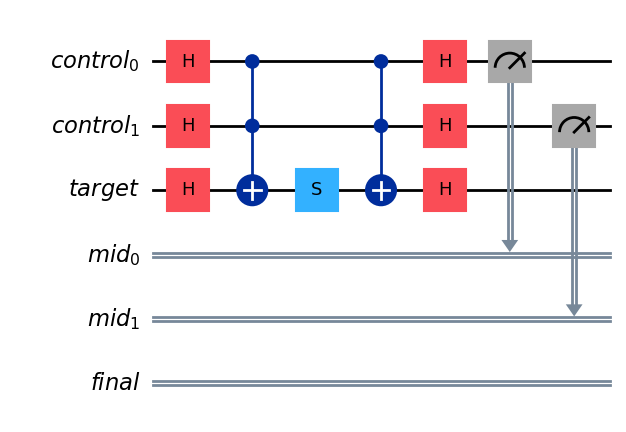

In [7]:
def trial(
    circuit: QuantumCircuit,
    target: QuantumRegister,
    controls: QuantumRegister,
    measures: ClassicalRegister,
):
    """Probabilistically perform Rx(theta) on the target, where cos(theta) = 3/5."""

    ####### your code goes here #######
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
qc.draw("mpl", cregbundle=False)

次の作業は測定値のチェックです。制御ビットの測定値が2つとも $|0\rangle$ の場合、適用されるゲートは$R_X(\theta)$で、$\cos(\theta) = \frac{3}{5}$です。測定値のいずれかが $|1\rangle$ であれば、適用されるゲートは単に$X$であり失敗を示します。したがって、対象となる量子ビットのコヒーレンスを乱すことなく、測定値から正しいゲートを適用したかどうかを知ることができるのです。

失敗した場合は、量子ビットをリセットしてもう一度やり直す必要があります。 失敗した場合に何が適用するかがわかっているので、一般的なハードウェアのリセットを使わなくても、この知識を使って効率的にリセットを実行することができます。2つの補助量子ビットについては、それぞれの測定値が $1$ であることを条件として、 $X$ ゲートを適用すれば良いのです。

````{admonition} Exercise3: 測定値のチェック
次のセルに`reset_controls`関数の中身を埋めて、次のステップで回路を変更できるようにしてください。

1. `measures`レジスターの最初のビットが1の場合、最初の制御量子ビットに$X$ゲートを適用する。
2. `measures`レジスターの2番目のビットが1の場合、2番目の制御量子ビットに$X$ゲートを適用する。

```python
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    ####### your code goes here #######


qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
reset_controls(qc, controls, mid_measure)
qc.measure(controls, mid_measure)
qc.draw("mpl", cregbundle=False)
```
````

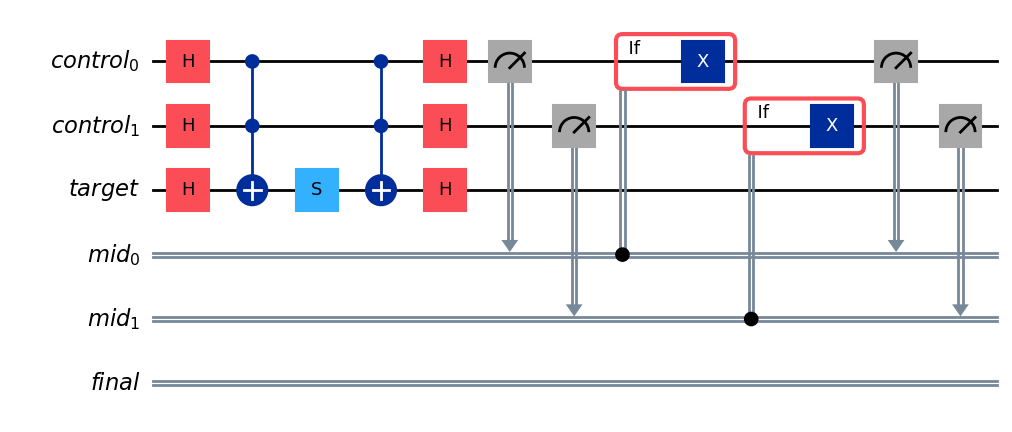

In [8]:
def reset_controls(
    circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister
):
    """Reset the control qubits if they are in |1>."""

    ####### your code goes here #######
    with circuit.if_test((measures[0], 1)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], 1)):
        circuit.x(controls[1])

qc = base.copy_empty_like()
trial(qc, target, controls, mid_measure)
reset_controls(qc, controls, mid_measure)
qc.measure(controls, mid_measure)
qc.draw("mpl", cregbundle=False)

あとは、条件が満たされなかった場合に、回路の実行を繰り返すだけです。
最後のExerciseでは、現在のDynamic circuitのサポートにおける2つの問題点を解決する必要があります。

最初の問題は、Qiskitが現在、**古典ビットに対するいかなる算術・論理演算の実行もサポートしていない**ことです。特に古典レジスターが特定の値を持って*いない*ことをチェックする機能はサポートしていません。現状、回路途中の測定値がビット列`00`で*ない*場合のみ、試行を繰り返す必要があります。この問題を回避するために、測定値が `00` に等しいことを条件とする if 文を作成し、空のブロックを**パス**して、**else** 分岐を使用して測定値が `00` でない場合に必要な論理を実行することになります。

2つ目の問題は、現在、私たちのハードウェアが**ループをサポートしていない**ことです。そのため、真の意味で成功するまで繰り返すループを実行することができません。そこで、この問題を解決するために、試行回路を一定回数だけ繰り返すことにします。

````{admonition} Exercise4: repeat until success

以下のコードセルに、シンドローム量子ビットの測定で試行を繰り返す必要があると判断された場合に実行されるロジックを `else` ブロックに記入してください。

1. ターゲット量子ビットをゼロ状態にリセットする。（すでに1の状態であることを知っていることを思い出してください）
2. 回路上の `trial` 関数を再び呼び出す。

```python
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        ####### your code goes here #######

```
````

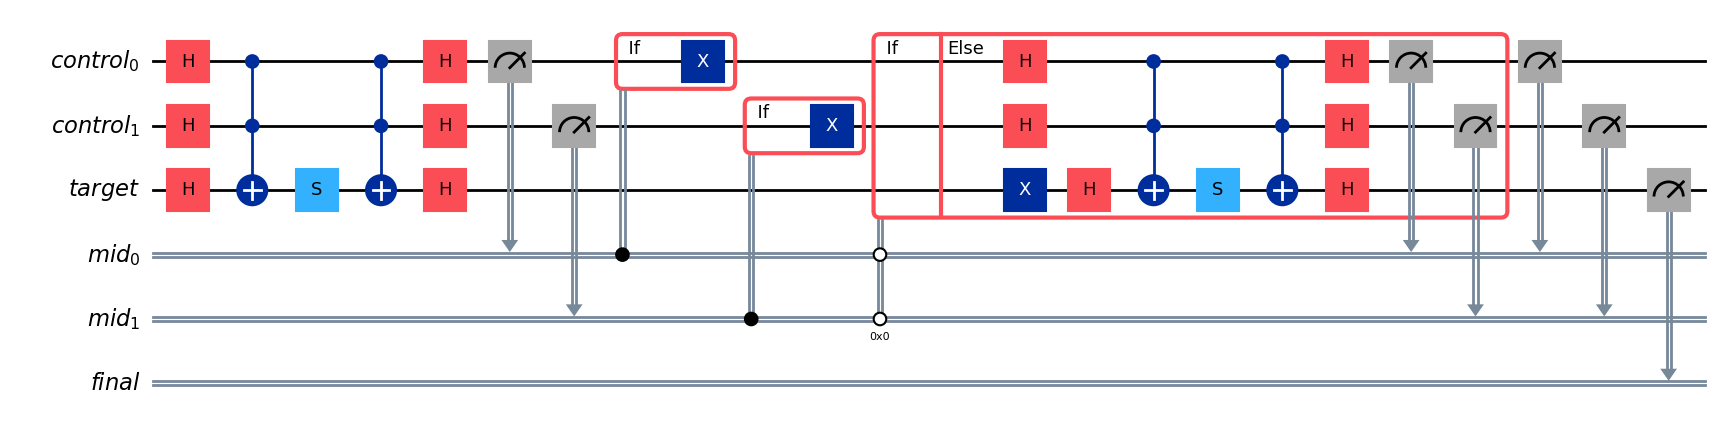

In [9]:
# Set the maximum number of trials
max_trials = 2

# Create a clean circuit with the same structure (bits, registers, etc)
# as the initial base we set up.
circuit = base.copy_empty_like()

# The first trial does not need to reset its inputs, since the controls
# are guaranteed to start in the |0> state.
trial(circuit, target, controls, mid_measure)

# Manually add the rest of the trials.  In the future, we will be
# able to use a dynamic `while` loop to do this, but for now, we
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        ####### your code goes here #######
        circuit.x(target[0])
        trial(circuit, target, controls, mid_measure)

# We need to measure the control qubits again to ensure we
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, let's measure our target, to check that we're
# getting the rotation we desired.
circuit.measure(target, final_measure)

circuit.draw("mpl", cregbundle=False)

シミュレーター上で回路を実行しましょう。

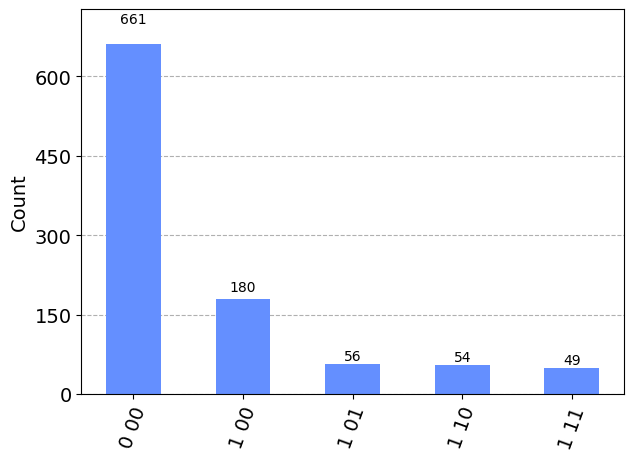

In [10]:
sim = AerSimulator()
job = sim.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

成功すると、結果は、2つの制御ビットの測定値が`00`の状態で終了します。

## ハードウェア上での実行

作成した回路を実際のハードウェアで動かしてみましょう！今回は、Dynamic circuit用に特別に調整された27qubitのPeekskillデバイスを使用します。しかし、実際のハードウェアで動かすのには時間がかかり、時にはエラーが発生することもあることを忘れないでください。他のChallenge参加者と渋滞の原因になるので、**このセルを何度も実行しないでください**。

In [11]:
# from qiskit_ibm_provider import IBMProvider

# provider = IBMProvider()

In [12]:
# hub = "YOUR_HUB"
# group = "YOUR_GROUP"
# project = "YOUR_PROJECT"

# backend_name = "ibm_peekskill"
# backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [13]:
# from qiskit import transpile

# qc_transpiled = transpile(circuit, backend)
# job = backend.run(qc_transpiled, shots=1000, dynamic=True)

In [14]:
# counts = job.result().get_counts()

# plot_histogram(counts)